# Final Project

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
def acc_loss(history, pdir):    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['accuracy'], label='Training')
    ax1.plot(history['val_accuracy'], label='Validation')
    ax1.grid()
    ax1.set_title('Accuracy', fontsize=15)
    ax1.set_xlabel('epoch', fontsize=12)
    ax1.set_ylabel('accuracy', fontsize=12)
    ax1.legend(loc='top left')
    ax2.plot(history['loss'], label='Training')
    ax2.plot(history['val_loss'], label='Validation')
    ax2.grid()
    ax2.set_title('Loss', fontsize=15)
    ax2.set_xlabel('epoch', fontsize=12)
    ax2.set_ylabel('loss', fontsize=12)
    ax2.legend(loc='top left')
    fig.suptitle('Training result', fontsize=18)
    fig.savefig(pdir, bbox_inches='tight')

In [14]:
 imgX, imgY, num_classes = 224, 224, 2

## image data generator: resize...etc.
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.15,
    rotation_range=10,
    zoom_range=0.1,
    validation_split=0.15    # validation split from training data
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size = 64
train_generator = train_datagen.flow_from_directory(
    directory='train',
    target_size=(imgX, imgY),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training'    # originated from train_datagen set as「training data」.
)

val_generator = train_datagen.flow_from_directory(
    directory='train',
    target_size=(imgX, imgY),
    batch_size=1,
    class_mode='binary',
    shuffle=False,
    subset='validation'    ## originated from train_datagen set as「validation data」.
)

test_generator = test_datagen.flow_from_directory(
    directory='test', 
    target_size=(imgX, imgY),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
def model_result(predict, name, test=test_generator.classes):
    mat1 = confusion_matrix(test, predict)
    sns.heatmap(mat1.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=train_generator.class_indices,
                yticklabels=train_generator.class_indices, cmap="YlGnBu")
    accuracy = np.sum(test == predict) / len(test)
    plt.xlabel('Original', fontsize=14)
    plt.ylabel('Predicted', fontsize=14)
    plt.title(str(name) + ' ACC:' + str(round(accuracy,4)))
    plt.savefig('./images/' + name + '_result.png', bbox_inches='tight')
    tn, fp, fn, tp = confusion_matrix(test, predict).ravel()
    recall  = round((tp / (tp + fn)), 4) # sensitivity
    precision  = round((tn / (tn + fp)), 4) # specificity
    f1 = round((2 / (1/recall + 1/precision)), 4)
    report = {name: [accuracy, recall, precision, f1]}
    report = pd.DataFrame(report, index=['Accuracy', 'Recall', 'Precision', 'F1'])
    print(report)

# References:

https://www.tensorflow.org/guide/keras/save_and_serialize

https://blog.csdn.net/weixin_30826761/article/details/95509779

https://blog.csdn.net/sinat_26917383/article/details/72859145

https://blog.csdn.net/sunbaigui/article/details/50807418

https://blog.csdn.net/langb2014/article/details/52787095

https://blog.csdn.net/cv_family_z/article/details/50789805

https://blog.csdn.net/qq_36330643/article/details/77367709

https://blog.csdn.net/wmy199216/article/details/71171401 

https://blog.csdn.net/weixin_41967600/article/details/105616647#GoogleNet%C2%A0

https://keras-cn.readthedocs.io/en/latest/other/application/

https://gist.github.com/baraldilorenzo/8d096f48a1be4a2d660d

In [6]:
from numba import cuda
cuda.select_device(0)
cuda.close()

##### 關於BFC算法：
##### 將內存分塊管理，按塊進行空間分配和釋放。
##### 通過split操作將大內存塊分解成用戶需要的小內存塊。
##### 通過merge操作合併小的內存塊，做到內存碎片回收
##### 通過bin這個抽象數據結構實現對空閒塊高效管理。

In [7]:
from keras.backend.tensorflow_backend import set_session

config=tf.compat.v1.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
tf.compat.v1.keras.backend.set_session(config)

### AlexNet

In [21]:
model = Sequential()
model.add(Conv2D(96, (11, 11), strides=(4, 4), input_shape=(224, 224, 3), padding='valid',
                 activation='relu', kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(256, (5, 5), strides=(1, 1), padding='same',activation='relu', kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='uniform'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax'))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.binary_crossentropy, 'accuracy'])

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 12, 12, 256)      

In [22]:
model_ckpt = ModelCheckpoint('./models/Alexnet_SGD.h5', monitor='val_acc', save_best_only=True)

# set_session(tf.Session(config=config))
start = time.time()

model_alexnet = model.fit(train_generator,
                          epochs=15,
                          validation_data=val_generator,
                          callbacks=[model_ckpt])
end = time.time()

print('\nAlexNet: {0} seconds.'.format(end - start))
model.save('./models/Alexnet_SGD_last.h5')

history_alexnet = pd.DataFrame(model_alexnet.history)
with open('./history/Alexnet_SGD_hist.json', 'w') as f:
    history_alexnet.to_json(f)

Epoch 1/15
70/70 [==============================] - 97s 1s/step - loss: 0.7419 - binary_crossentropy: 0.7396 - accuracy: 0.5959 - val_loss: 0.5408 - val_binary_crossentropy: 0.6253 - val_accuracy: 0.7430
Epoch 2/15
70/70 [==============================] - 85s 1s/step - loss: 0.5159 - binary_crossentropy: 0.5163 - accuracy: 0.7700 - val_loss: 0.4755 - val_binary_crossentropy: 0.5881 - val_accuracy: 0.7430
Epoch 3/15
70/70 [==============================] - 88s 1s/step - loss: 0.4206 - binary_crossentropy: 0.4210 - accuracy: 0.8272 - val_loss: 0.4201 - val_binary_crossentropy: 0.5559 - val_accuracy: 0.7430
Epoch 4/15
70/70 [==============================] - 90s 1s/step - loss: 0.3831 - binary_crossentropy: 0.3792 - accuracy: 0.8507 - val_loss: 0.5057 - val_binary_crossentropy: 0.5110 - val_accuracy: 0.7532
Epoch 5/15
70/70 [==============================] - 87s 1s/step - loss: 0.3463 - binary_crossentropy: 0.3447 - accuracy: 0.8642 - val_loss: 0.6160 - val_binary_crossentropy: 0.4666 - v

In [23]:
hist = model_alexnet.history
print('Average Training Accuracy', np.average(hist['accuracy']))
print('Average Validation Accuracy', np.average(hist['val_accuracy']))

Average Training Accuracy 0.86744857
Average Validation Accuracy 0.7813299258550008


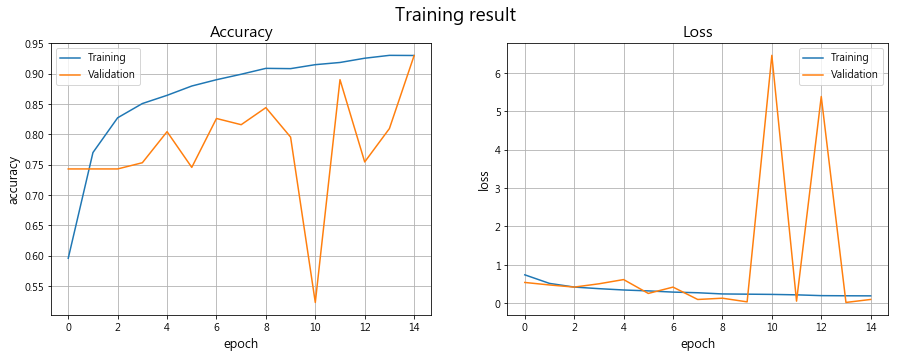

In [24]:
acc_loss(hist, './images/Alexnet_SGD.png')

In [25]:
score = model.evaluate(test_generator, verbose=1)
print('AlexNet - Test loss:', score[0])
print('AlexNet - Test accuracy:', score[2])
predict = np.ravel(model.predict_classes(test_generator, batch_size=None, verbose=0))

624/624 [==============================] - 9s 14ms/step
AlexNet - Test loss: 0.11778854578733444
AlexNet - Test accuracy: 0.7980769276618958


          AlexNet_SGD
Accuracy     0.798077
Recall       0.989700
Precison     0.478600
F1           0.645200


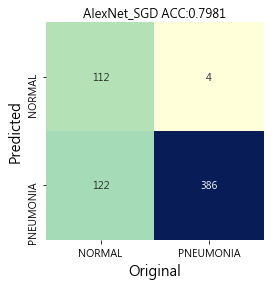

In [26]:
model_result(predict, 'AlexNet_SGD')

In [17]:
model = load_model('./models/Alexnet_SGD_last.h5')

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.binary_crossentropy, 'accuracy'])

### VGG19

In [27]:
from keras.applications.vgg19 import VGG19

In [28]:
model = Sequential()

vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = False

model.add(vgg_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(), # Adam(learning_rate=0.0001)
              metrics=[tf.keras.metrics.binary_crossentropy,'accuracy'])

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 25088)             100352    
_________________________________________________________________
dense_21 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 128)               512       
_________________________________________________________________
dense_22 (Dense)             (None, 32)               

In [29]:
# earlystop = EarlyStopping(monitor='val_acc', patience=5, mode='max', verbose=1)
model_ckpt = ModelCheckpoint(filepath='./models/Vgg19_RMSprop.h5', monitor='val_acc', save_best_only=True)

start = time.time()

model_vgg19 = model.fit(train_generator, 
                        epochs=15,
                        validation_data=val_generator,
                        callbacks=[model_ckpt])

end = time.time()
print('\nVGG19 took {0} seconds.'.format(end - start))

model.save('./models/Vgg19_RMSprop_last.h5')

history_vgg19 = pd.DataFrame(model_vgg19.history)
with open('./history/Vgg19_RMSprop_hist.json', 'w') as f:
    history_vgg19.to_json(f)

Epoch 1/15
70/70 [==============================] - 98s 1s/step - loss: 0.3114 - binary_crossentropy: 0.3093 - accuracy: 0.8899 - val_loss: 1.0589 - val_binary_crossentropy: 0.2934 - val_accuracy: 0.9373
Epoch 2/15
70/70 [==============================] - 88s 1s/step - loss: 0.1723 - binary_crossentropy: 0.1728 - accuracy: 0.9524 - val_loss: 0.0974 - val_binary_crossentropy: 0.2950 - val_accuracy: 0.8465
Epoch 3/15
70/70 [==============================] - 88s 1s/step - loss: 0.1395 - binary_crossentropy: 0.1393 - accuracy: 0.9605 - val_loss: 0.0815 - val_binary_crossentropy: 0.3119 - val_accuracy: 0.8568
Epoch 4/15
70/70 [==============================] - 88s 1s/step - loss: 0.1152 - binary_crossentropy: 0.1147 - accuracy: 0.9668 - val_loss: 0.0527 - val_binary_crossentropy: 0.1131 - val_accuracy: 0.9514
Epoch 5/15
70/70 [==============================] - 90s 1s/step - loss: 0.0949 - binary_crossentropy: 0.0948 - accuracy: 0.9705 - val_loss: 0.0076 - val_binary_crossentropy: 0.0894 - v

In [30]:
hist = model_vgg19.history
print('Average Training Accuracy', np.average(hist['accuracy']))
print('Average Validation Accuracy', np.average(hist['val_accuracy']))

Average Training Accuracy 0.9654489
Average Validation Accuracy 0.9477408369382222


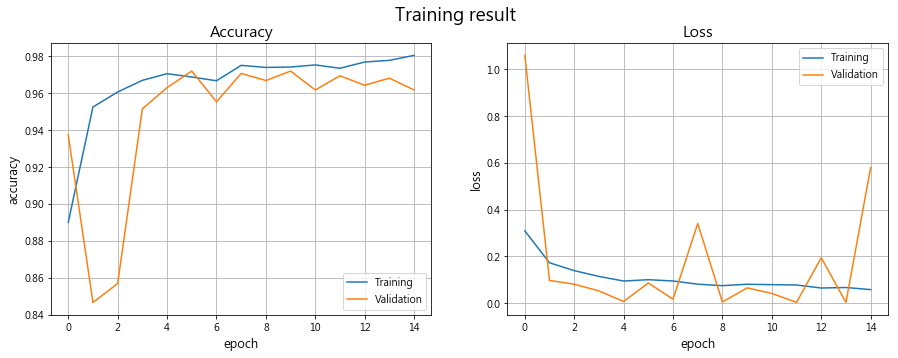

In [31]:
acc_loss(hist, './images/Vgg19_RMSprop.png')

In [29]:
score = model.evaluate(test_generator, verbose=1)
print('Vgg19 - Test loss:', score[0])
print('Vgg19 - Test accuracy:', score[2])
predict = (model.predict_classes(test_generator, batch_size = None, verbose=0)).ravel()

624/624 [==============================] - 12s 20ms/step
Vgg19 - Test loss: 0.03209325298666954
Vgg19 - Test accuracy: 0.8942307829856873


          Vgg19_RMSprop
Accuracy       0.894231
Recall         0.979500
Precison       0.752100
F1             0.850900


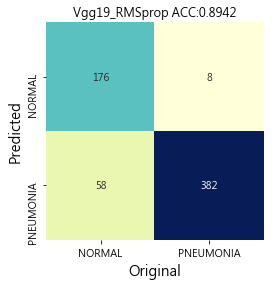

In [30]:
model_result(predict, 'Vgg19_RMSprop')

In [27]:
model = load_model('./models/Vgg19_RMSprop_last.h5')

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(), # Adam(learning_rate=0.0001)
              metrics=[tf.keras.metrics.binary_crossentropy,'accuracy'])